In [15]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Exploración de los tiempos de erupción

In [16]:
target_csv = pd.read_csv("train.csv")
target_csv

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


In [17]:
target_csv.describe()

,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03
mean,1.074694e+09,2.284891e+07
std,6.161966e+08,1.348439e+07
min,5.131810e+05,6.250000e+03
25%,5.527934e+08,1.127016e+07
50%,1.066153e+09,2.246559e+07
75%,1.606350e+09,3.434356e+07
max,2.146939e+09,4.904609e+07


<AxesSubplot:xlabel='time_to_eruption', ylabel='Count'>

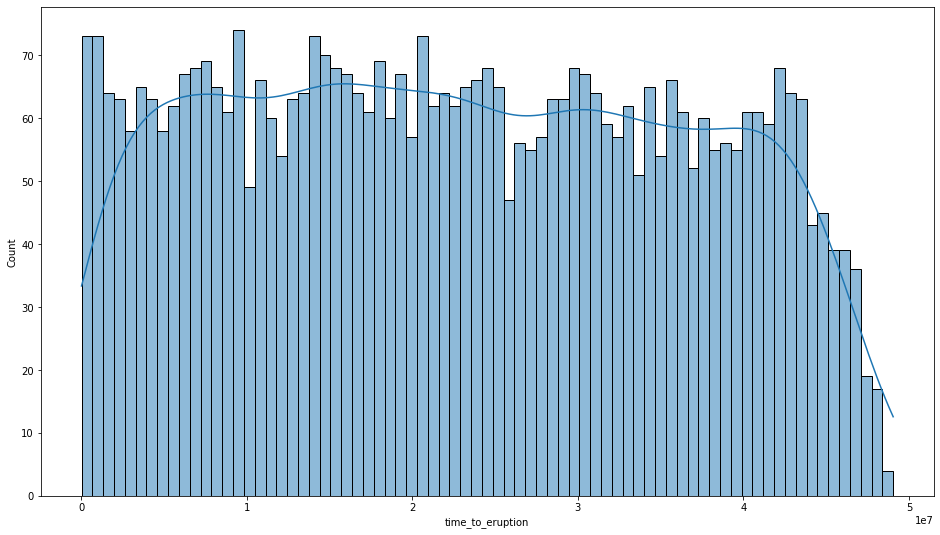

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
sns.histplot(data=target_csv, x="time_to_eruption", bins=75, kde=True, ax=ax)

Podemos ver de las gráficas anteriores que la distribución de los tiempos de erupción es simétrica pero no tiene forma de campana. Incluso se podría pensar que pareciera uniforme excepto por el límite superior que desciende.

# Exploración del sensado

In [19]:
train_dir_path = "train"
train_filenames = os.listdir(train_dir_path)
len(train_filenames)

4431

## Estadísticas por archivo

In [96]:
def get_stats_per_df(df):
    aggs = df.agg(["count", np.nanmean, np.nanstd, np.nanmin, np.nanmax])
    aggs = aggs.stack()
    aggs.index = aggs.index.map(lambda t:f"{t[1]}_{t[0]}")
    return aggs

In [ ]:
%%time
stats_per_file = []
for i,filename in enumerate(train_filenames,1):
    df = pd.read_csv(os.path.join(train_dir_path, filename), dtype="Int16")
    temporal_stats = get_stats_per_df(df)
    stats_per_file.append(temporal_stats)
    if i%50 == 0:
        print(i)

In [98]:
df_stats_per_file = pd.DataFrame(stats_per_file, index=target_csv.segment_id)
df_stats_per_file.to_csv("csvs/stats_per_file2.csv")

## Estadísticas en total
* número de elementos
* La suma de los elementos
* La suma de los elementos elevados al cuadrado
* El mínimo
* El máximo

In [59]:
def get_stats_vec(data):
    data_notnans = data[~np.isnan(data)]
    stats = [len, np.sum, lambda x:np.sum(x**2),
             lambda x:np.min(x) if len(x) else np.inf,
             lambda x:np.max(x) if len(x) else -np.inf]
    vec = [stat(data_notnans) for stat in stats]
    vec = np.array(vec)
    return vec

In [60]:
def get_stats_vecs(df):
    vecs = [get_stats_vec(df[column]) for column in df.columns]
    matrix = np.vstack(vecs)
    return matrix

In [61]:
%%time
stats = np.zeros(shape=(10,5))
stats[:,3] = np.inf
stats[:,4] = -np.inf
for filenames in train_filenames:
    df = pd.read_csv( os.path.join(train_dir_path, filename) )
    current_stats = get_stats_vecs(df)
    stats[:,:3] += current_stats[:,:3]
    stats[:,3] = np.minimum(stats[:,3], current_stats[:,3])
    stats[:,4] = np.maximum(stats[:,4], current_stats[:,4])

CPU times: user 4min 19s, sys: 36.6 s, total: 4min 56s
Wall time: 4min 14s


In [62]:
def get_stats_df(matrix):
    sensors = [f"sensor_{i+1}" for i in range(10)]
    stats_names = ["count", "mean", "std", "min", "max"]
    
    nrows, ncols = matrix.shape
    
    stats_vecs = []
    for row in range(nrows): # for every sensor
        count = matrix[row,0]
        total_sum = matrix[row,1]
        mean = total_sum/count
        total_squared_sum = matrix[row,2]
        std = np.sqrt( (total_squared_sum - count*mean**2)/(count-1) )
        minimum = matrix[row,3]
        maximum = matrix[row,4]
        stats = [count, mean, std, minimum, maximum]
        stats_vecs.append(np.array(stats))
        
    new_matrix = np.vstack(stats_vecs)
    
    stats_df = pd.DataFrame(new_matrix, columns=stats_names, index=sensors)
    
    return stats_df

In [63]:
whole_stats = get_stats_df(stats)
whole_stats

,count,mean,std,min,max
sensor_1,265864431.0,0.025250,203.303099,-1171.0,1278.0
sensor_2,265864431.0,-0.431776,418.222197,-4759.0,4118.0
sensor_3,265864431.0,0.233829,178.179004,-1288.0,1212.0
sensor_4,265864431.0,0.281562,200.602547,-1280.0,1532.0
sensor_5,265864431.0,-0.000650,161.583577,-1225.0,1370.0
sensor_6,265864431.0,0.044916,299.005016,-3226.0,2575.0
sensor_7,265864431.0,4.590190,204.956910,-986.0,983.0
sensor_8,265864431.0,-2.975500,247.542130,-934.0,1060.0
sensor_9,265864431.0,2.170547,196.562165,-1210.0,1316.0
sensor_10,265864431.0,-120.953801,937.478541,-3743.0,3229.0


In [64]:
whole_stats.to_csv("csvs/whole_stats.csv",index=False)

----------

In [ ]:
data = pd.read_csv("")